In [1]:
# Montar Google Drive para acceder al dataset
from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/MyDrive/MNA/Colab Notebooks/MNA/Navegacion autonoma/Actividad 4.1 - Deteccion de Peatones con Keras/Train pics'



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# Importar librerías usadas en la aplicación
# !pip install keras

import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import keras #Para construir redes neuronales
from keras.models import Sequential #Modelo secuencial
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout #Dense para capas conectadas y Flatten para aplanar la entrada
from keras.optimizers import Adam #Optimizador Adam
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator #Cargar y procesar imagenes desde carpetas.
                                                                    #Se utiliza Tensorflow porque en versiones modernas de Keras, ImageDataGenerator
                                                                    #ya no se importa desde Keras, se debe importar ahora desde tensorflow.keras

In [3]:
# # Normalización y división de entrenamiento/validación
# datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# # Crear generador para entrenamiento
# train_gen = datagen.flow_from_directory(
#     data_dir,               #Dirección a las imágenes
#     target_size=(64, 128),  # Tamaño al que se redimensionan las imágenes
#     batch_size=32,          # Agrupa las imagenes en paquetes de 32 para ser procesadas en paquetes
#     class_mode='binary',  # Salida binaria
#     subset='training'  # Usa el 80% para entrenamiento
# )

# # Crear generador para validación
# val_gen = datagen.flow_from_directory(
#     data_dir,
#     target_size=(64, 128),
#     batch_size=32,
#     class_mode='binary',
#     subset='validation'  # Usa el 20% para validación
# )


# Data augmentation + normalización para entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normaliza los pixeles a [0,1]
    validation_split=0.2,    # Divide el dataset en entrenamiento y validación
    rotation_range=10,       # Rota imágenes hasta 10 grados para variedad
    width_shift_range=0.1,   # Desplaza horizontalmente hasta 10%
    height_shift_range=0.1,  # Desplaza verticalmente hasta 10%
    zoom_range=0.1,          # Zoom aleatorio hasta 10%
    horizontal_flip=True     # Voltea horizontalmente (solo si aplica a tu problema)
)

# Solo normalización para validación (sin augmentations)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Generador para entrenamiento usando augmentations
train_gen = train_datagen.flow_from_directory(
    data_dir,               # Carpeta con imágenes organizadas en subcarpetas por clase
    target_size=(64, 128),  # Redimensiona imágenes a 64x128 (ancho x alto)
    batch_size=32,          # Procesa en lotes de 32 imágenes
    class_mode='binary',    # Clasificación binaria
    subset='training'       # Usa el 80% para entrenamiento
)

# Generador para validación sin augmentations
val_gen = val_datagen.flow_from_directory(
    data_dir,
    target_size=(64, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'     # Usa el 20% para validación
)

Found 1467 images belonging to 2 classes.
Found 365 images belonging to 2 classes.


In [4]:
print(f"Imágenes en entrenamiento: {train_gen.samples}")
print(f"Imágenes en validación: {val_gen.samples}")
print(f"Clases: {train_gen.class_indices}")

Imágenes en entrenamiento: 1467
Imágenes en validación: 365
Clases: {'negative': 0, 'positive': 1}


In [5]:
# Crear modelo secuencial CNN
model = Sequential()
# # Aplanar la imagen de entrada (64x128x3 - vector)
# model.add(Flatten(input_shape=(128, 64, 3)))  # alto=128, ancho=64, canales=3 - 24,576 entradas

#Primera capa convolucional
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 64, 3)))  # Filtros 3x3
model.add(MaxPooling2D(pool_size=(2, 2)))  # Reduce tamaño espacial a la mitad

#Segunda capa convolucional
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#Tercera capa convolucional
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Aplanar para conectar con capas densas
model.add(Flatten())

# Capa oculta totalmente conectada con Dropout para regularización
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(1, activation='sigmoid')) # Capa de salida: clasificación binaria

# Callbacks: parada temprana y reducción del LR si no mejora
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate = 0.001), loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
#Resumen del modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 62, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 6, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10752)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,376,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,469,761 (5.61 MB)

 Trainable params: 1,469,761 (5.61 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Entrenar el modelo
hist = model.fit(train_gen, validation_data=val_gen, verbose = 2, epochs=20, callbacks=[early_stop, reduce_lr], shuffle = 'true')


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
46/46 - 34s - 742ms/step - accuracy: 0.6967 - loss: 0.5624 - val_accuracy: 0.8438 - val_loss: 0.3434 - learning_rate: 1.0000e-03
Epoch 2/20
46/46 - 25s - 547ms/step - accuracy: 0.7580 - loss: 0.4857 - val_accuracy: 0.8959 - val_loss: 0.3288 - learning_rate: 1.0000e-03
Epoch 3/20
46/46 - 25s - 545ms/step - accuracy: 0.7785 - loss: 0.4597 - val_accuracy: 0.8932 - val_loss: 0.3002 - learning_rate: 1.0000e-03
Epoch 4/20
46/46 - 25s - 538ms/step - accuracy: 0.7860 - loss: 0.4416 - val_accuracy: 0.8301 - val_loss: 0.3516 - learning_rate: 1.0000e-03
Epoch 5/20
46/46 - 41s - 893ms/step - accuracy: 0.8323 - loss: 0.3971 - val_accuracy: 0.9151 - val_loss: 0.2296 - learning_rate: 1.0000e-03
Epoch 6/20
46/46 - 25s - 542ms/step - accuracy: 0.8146 - loss: 0.3946 - val_accuracy: 0.8986 - val_loss: 0.2525 - learning_rate: 1.0000e-03
Epoch 7/20

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
46/46 - 42s - 915ms/step - accuracy: 0.8234 - loss: 0.3882 - val_accurac

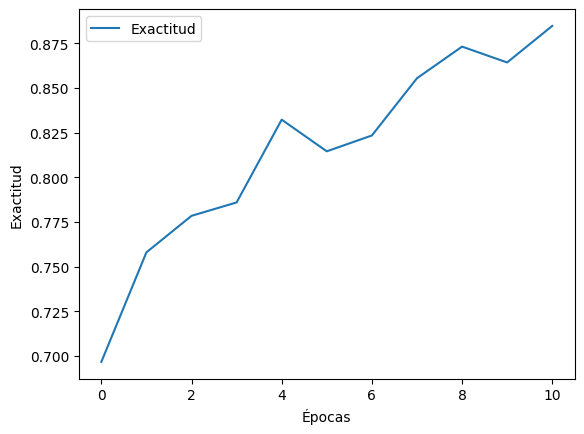

In [8]:
#Graficar error y exactitud del modelo
plt.plot(hist.history['accuracy'])
plt.legend(['Exactitud'])
plt.xlabel('Épocas')
plt.ylabel('Exactitud')
plt.show()

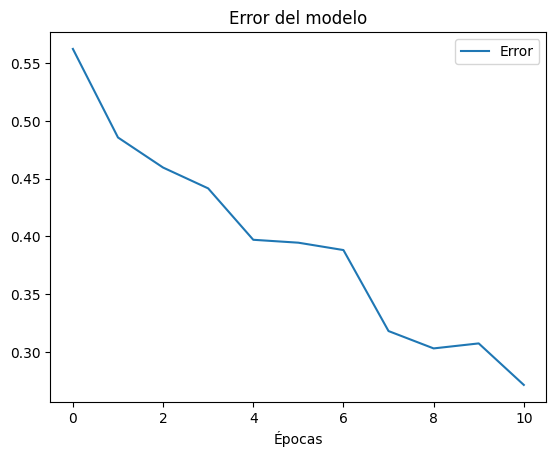

In [10]:
plt.plot(hist.history['loss'])
plt.legend(['Error'])
plt.title('Error del modelo')
plt.xlabel('Épocas')
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9087 - loss: 0.2036
Precisión en test: 0.9123, Pérdida: 0.2114


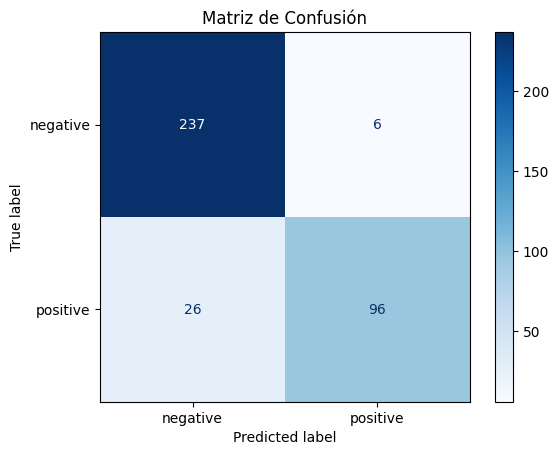

In [17]:
# Listas para almacenar todas las imágenes y etiquetas
X_test = []
y_test = []

# Calculamos cuántos batchs hay en total en val_gen
num_batches = int(np.ceil(val_gen.samples / val_gen.batch_size))

# Recorremos todos los lotes del generador de validación
for _ in range(num_batches):
    x_batch, y_batch = next(val_gen) # Obtenemos un lote de imágenes y etiquetas
    X_test.extend(x_batch)          # Agregamos las imágenes a la lista
    y_test.extend(y_batch)

# Convertimos las listas a arreglos
X_test = np.array(X_test)
y_test = np.array(y_test)

# Predecir las clases
y_predict = (model.predict(X_test) > 0.5).astype(int).flatten()

# Evaluar en conjunto de prueba
loss, acc = model.evaluate(X_test, y_test)
print(f"Precisión en test: {acc:.4f}, Pérdida: {loss:.4f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_predict)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_gen.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()
